# Курсовой проект

## Задача<a class="anchor" id="task"></a>

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).

### Примерное описание этапов выполнения курсового проекта

**Построение модели классификации**
1. Обзор обучающего датасета
2. Анализ данных
3. Обработка пропусков
4. Обработка выбросов
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и построения признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных
**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Подключение библиотек и скриптов

In [1]:
%%time
import pandas as pd
import numpy as np
import pickle
import random
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import mannwhitneyu

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Wall time: 3.24 s


## Функции
### Метрики качества модели

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [3]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("TEST\n", round(f1_score(y_valid, y_valid_pred), 3))
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

### Балансировка классов

In [4]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

### Подбор оптимального размера выборки, кривая обучения

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

### Выбор порога вероятности для определения класса

In [6]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

### Важность признаков

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

## Пути к директориям и файлам

In [8]:
DATA_ROOT = Path('./data_source/')
MODELS_PATH = Path('./models/')

# input
TRAIN_DATASET_PATH = DATA_ROOT / 'train.csv'
TEST_DATASET_PATH = DATA_ROOT / 'test.csv'
SUBMIT_DATASET_PATH = DATA_ROOT / 'sample_submission.csv'

# output
PREPARED_TRAIN_DATASET_PATH = 'train_prep.csv'
PREPARED_TEST_DATASET_PATH = 'test_prep.csv'
PREDICTION_SET = 'sample_submission.csv'

#### Загрузка данных

In [9]:
df_train_base = pd.read_csv(TRAIN_DATASET_PATH)
df_test_base = pd.read_csv(TEST_DATASET_PATH)

In [10]:
df_train_base.shape

(7500, 17)

In [11]:
df_test_base.shape

(2500, 16)

## Анализ данных
### Обзор обучающей выборки

In [12]:
df_train_base.head().T

,0,1,2,3,4
Home Ownership,Own Home,Own Home,Home Mortgage,Own Home,Rent
Annual Income,482087.0,1025487.0,751412.0,805068.0,776264.0
Years in current job,NaN,10+ years,8 years,6 years,8 years
Tax Liens,0.0,0.0,0.0,0.0,0.0
Number of Open Accounts,11.0,15.0,11.0,8.0,13.0
Years of Credit History,26.3,15.3,35.0,22.5,13.6
Maximum Open Credit,685960.0,1181730.0,1182434.0,147400.0,385836.0
Number of Credit Problems,1.0,0.0,0.0,1.0,1.0
Months since last delinquent,NaN,NaN,NaN,NaN,NaN
Bankruptcies,1.0,0.0,0.0,1.0,0.0


In [13]:
df_train_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Из описания обучающей выборки видим, что есть пропуски в признаках:
 - Annual Income
 - Years in current job
 - Months since last delinquent
 - Credit Score
 - Bankruptcies

In [14]:
df_train_base.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


#### Выделение целевой переменной и групп признаков

In [15]:
TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                     'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

#### Анализ значений целевой переменной

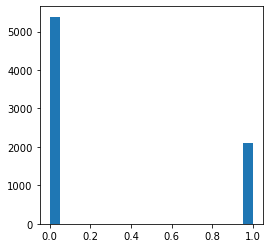

In [16]:
df_train_base[TARGET_NAME].hist(figsize=(4, 4), bins=20, grid=False);

In [17]:
df_train_base[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Соотношение класов в целевой переменной примерно 2 к 1. Дисбаланс классов присутствует, но его влияние на результат предсказаний не слишком велико. При построении модели можно будет сделать балансировку классов.

#### Анализ числовых признаков

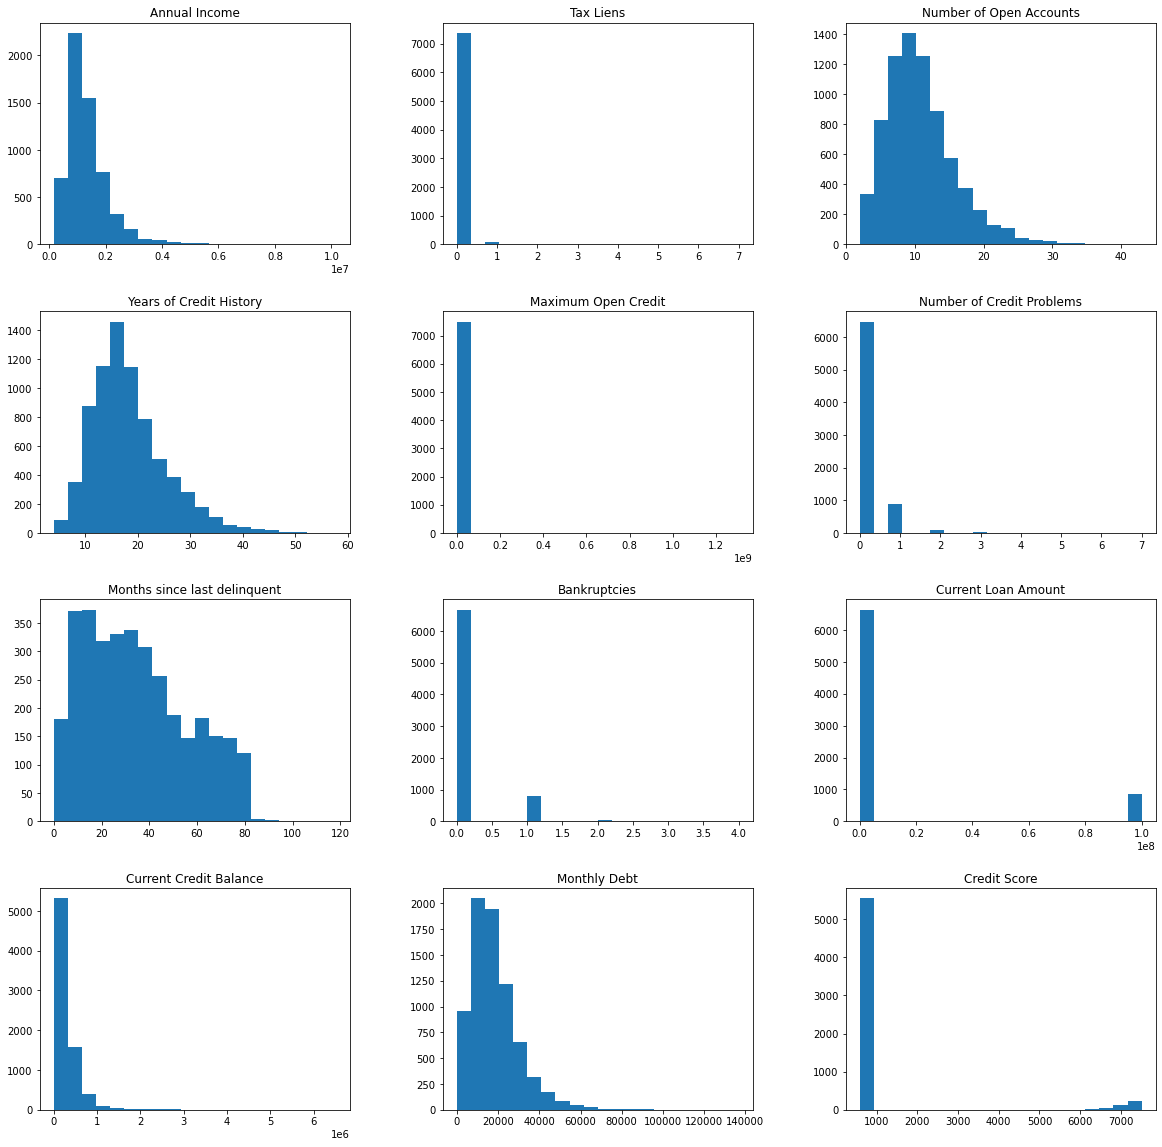

In [18]:
df_train_base[NUM_FEATURE_NAMES].hist(figsize=(20, 20), bins=20, grid=False);

In [19]:
for num_colname in df_train_base.select_dtypes(include='float64').columns:
    print(str(num_colname) + '\n\n' + str(df_train_base[num_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Annual Income

1338113.0    4
969475.0     4
1161660.0    4
1043651.0    4
1058376.0    4
            ..
1272316.0    1
712082.0     1
695476.0     1
678889.0     1
402192.0     1
Name: Annual Income, Length: 5478, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Open Accounts

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      

В признаке `Current Loan Amount` 870 записей имеют значение 99 999 999.0, что явно указывет на некорректность внесенных данных и является выбросом. При обработке необходимо будет это исправить заменой значений.<br>
Признаки `Current Credit Balance, Monthly Debt, Current Loan Amount и Credit Score`судя по графикам также имеют выбросы. Рассмотрим эти признаки отдельно.

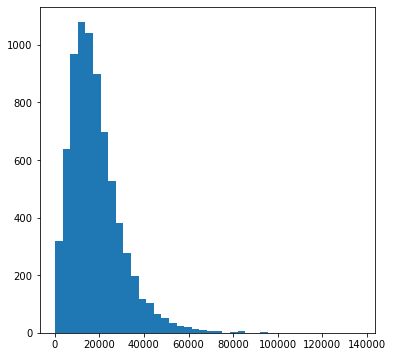

In [20]:
df_train_base['Monthly Debt'].hist(figsize=(6, 6), bins=40, grid=False);

Значения `Monthly Debt` более 60 000 можно считать выбросами

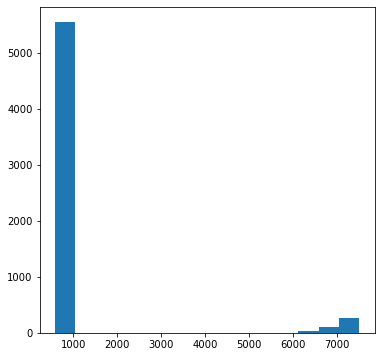

In [21]:
df_train_base['Credit Score'].hist(figsize=(6, 6), bins=15, grid=False);

Значения `Credit Score` более 6000 являются выбросами

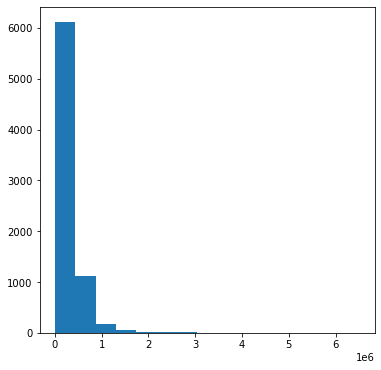

In [22]:
df_train_base['Current Credit Balance'].hist(figsize=(6, 6), bins=15, grid=False);

Значения `Current Credit Balance` более 200 000 также можно откорректировать

#### Анализ категориальных признаков

In [23]:
for cat_colname in df_train_base.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train_base[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

#### Корреляция признаков с целевой переменной

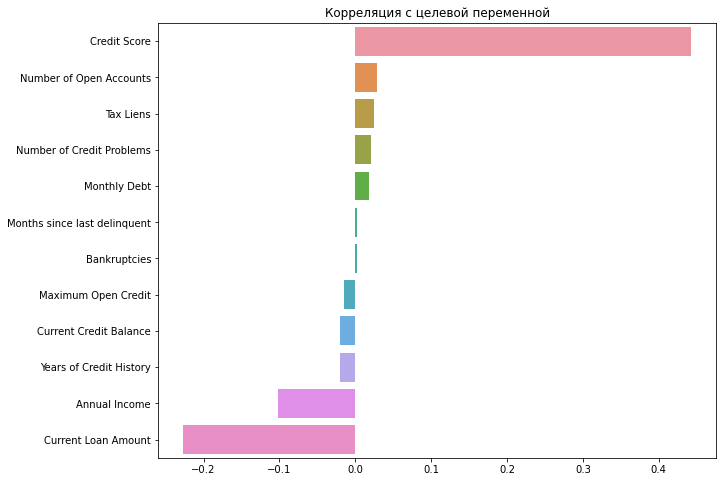

In [24]:
corr_with_target = df_train_base[NUM_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция с целевой переменной')
plt.show()

Наблюдаем сильную прямую корреляцию целевой переменной с количественным признаком `'Credit Score'` и обратную корреляцию с признаками `'Annual Income'` и `'Current Loan Amount'`

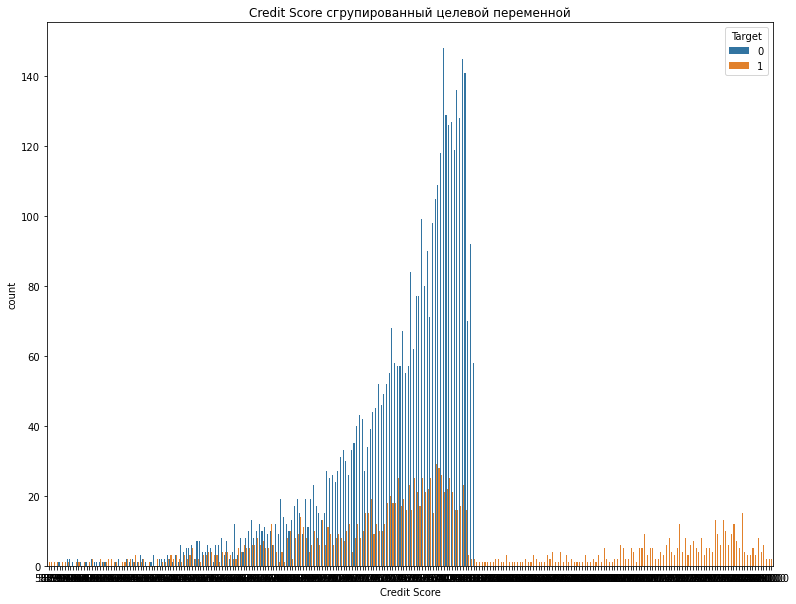

Wall time: 2.45 s


In [25]:
%%time
plt.figure(figsize=(13, 10))

sns.countplot(x="Credit Score", hue=TARGET_NAME, data=df_train_base)
plt.title('Credit Score сгрупированный целевой переменной')
plt.legend(title='Target', loc='upper right')

plt.show()

### Обзор тестовой выборки

In [26]:
df_test_base.head().T

,0,1,2,3,4
Home Ownership,Rent,Rent,Home Mortgage,Home Mortgage,Home Mortgage
Annual Income,NaN,231838.0,1152540.0,1220313.0,2340952.0
Years in current job,4 years,1 year,3 years,10+ years,6 years
Tax Liens,0.0,0.0,0.0,0.0,0.0
Number of Open Accounts,9.0,6.0,10.0,16.0,11.0
Years of Credit History,12.5,32.7,13.7,17.0,23.6
Maximum Open Credit,220968.0,55946.0,204600.0,456302.0,1207272.0
Number of Credit Problems,0.0,0.0,0.0,0.0,0.0
Months since last delinquent,70.0,8.0,NaN,70.0,NaN
Bankruptcies,0.0,0.0,0.0,0.0,0.0


In [27]:
df_test_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Из описания тестовой выборки видим, что есть пропуски в признаках:
 - Annual Income
 - Years in current job
 - Months since last delinquent
 - Credit Score
 - Bankruptcies
 
 Пропуски в тех же признаках, что и в обучающей выборке.

In [28]:
df_test_base.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,1987.0,1.366922e+06,9.171252e+05,106533.0,852311.50,1178475.0,1629734.5,14975610.0
Tax Liens,2500.0,3.520000e-02,3.862909e-01,0.0,0.00,0.0,0.0,15.0
Number of Open Accounts,2500.0,1.118440e+01,4.852774e+00,1.0,8.00,10.0,14.0,48.0
Years of Credit History,2500.0,1.832592e+01,7.254659e+00,3.9,13.40,17.0,22.1,53.4
Maximum Open Credit,2500.0,7.105704e+05,1.511983e+06,0.0,278586.00,478676.0,802598.5,54484386.0
Number of Credit Problems,2500.0,1.620000e-01,5.598941e-01,0.0,0.00,0.0,0.0,15.0
Months since last delinquent,1142.0,3.418126e+01,2.202428e+01,0.0,16.00,30.0,50.0,82.0
Bankruptcies,2497.0,1.069283e-01,3.571893e-01,0.0,0.00,0.0,0.0,5.0
Current Loan Amount,2500.0,1.215572e+07,3.226097e+07,15422.0,187126.50,322366.0,522582.5,99999999.0
Current Credit Balance,2500.0,2.963966e+05,3.783020e+05,0.0,110114.50,207385.0,366348.5,6030087.0


#### Анализ числовых признаков

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>],
       [<AxesSubplot:title={'center':'Years of Credit History'}>,
        <AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>],
       [<AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>,
        <AxesSubplot:title={'center':'Current Loan Amount'}>],
       [<AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>]], dtype=object)

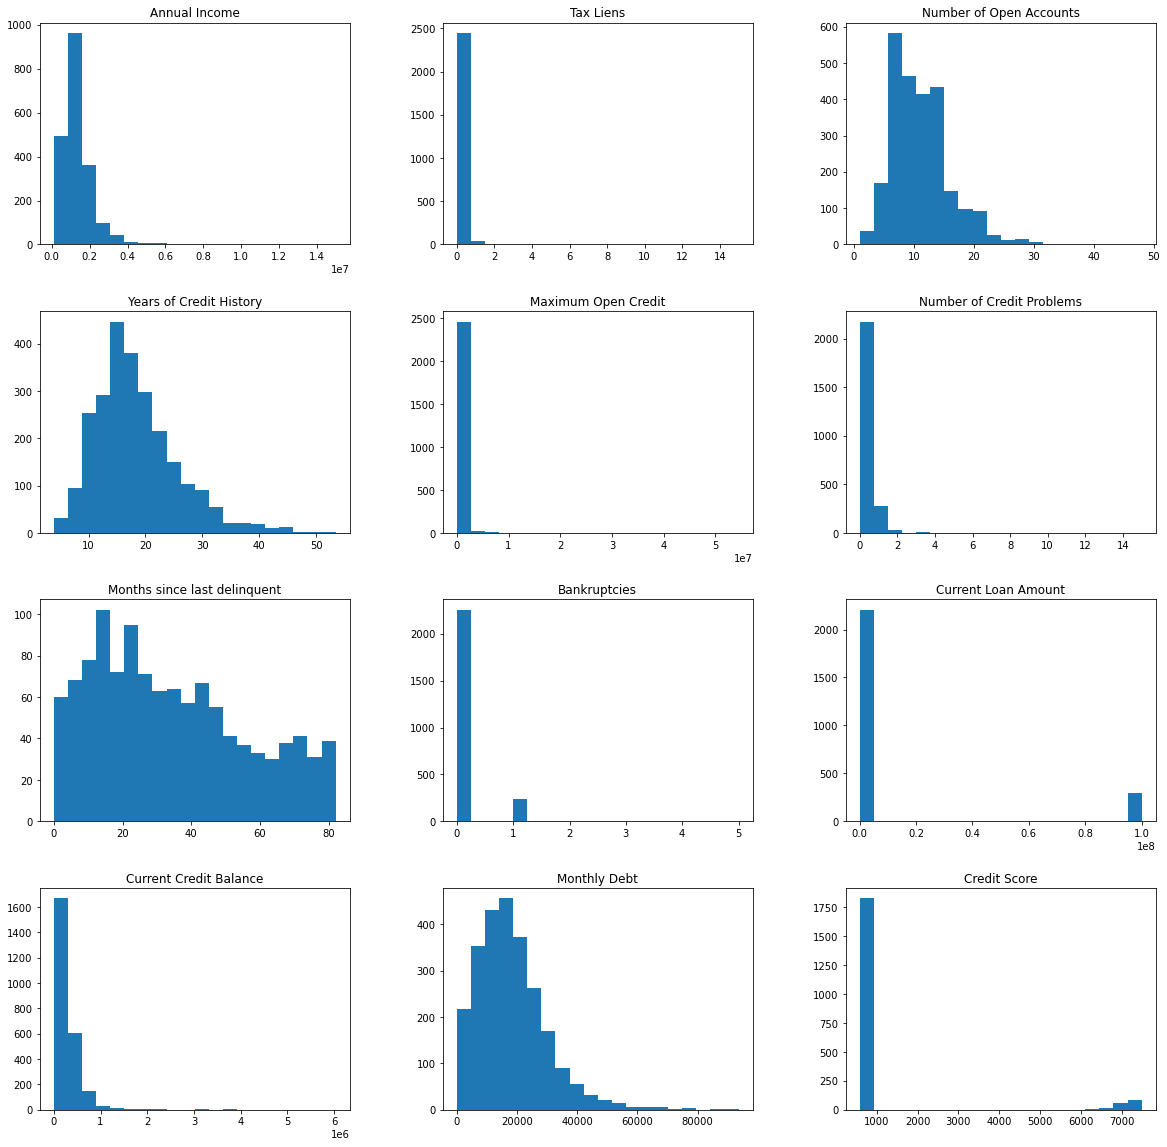

In [29]:
df_test_base[NUM_FEATURE_NAMES].hist(figsize=(20, 20), bins=20, grid=False)

In [30]:
for num_colname in df_test_base.select_dtypes(include='float64').columns:
    print(str(num_colname) + '\n\n' + str(df_test_base[num_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Annual Income

1025145.0    3
1328803.0    3
1214993.0    3
1237109.0    3
1204619.0    2
            ..
763838.0     1
1221168.0    1
651377.0     1
1735479.0    1
1694439.0    1
Name: Annual Income, Length: 1929, dtype: int64
****************************************************************************************************

Tax Liens

0.0     2445
1.0       45
2.0        5
5.0        1
4.0        1
6.0        1
3.0        1
15.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Open Accounts

9.0     245
8.0     223
10.0    218
11.0    211
12.0    204
6.0     183
13.0    178
7.0     176
14.0    159
5.0     106
15.0     97
16.0     81
17.0     66
4.0      63
18.0     52
19.0     46
20.0     37
21.0     29
3.0      29
22.0     26
23.0     17
27.0     10
24.0      9
2.0       7
30.0      6
25.0      6
26.0      5
28.0      3
33.0      2
31.0      1
1.0       1
36.0      1
29.0      1
34

В признаке `Current Loan Amount` 870 записей имеют значение 99 999 999.0, что явно указывет на некорректность внесенных данных и является выбросом. При обработке необходимо будет это исправить заменой значений.<br>
Признаки `Current Credit Balance, Monthly Debt, Current Loan Amount и Credit Score`судя по графикам также имеют выбросы. Рассмотрим эти признаки отдельно.

<AxesSubplot:>

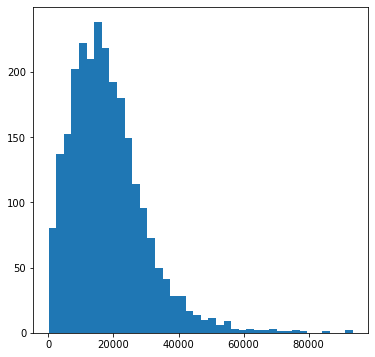

In [31]:
df_test_base['Monthly Debt'].hist(figsize=(6, 6), bins=40, grid=False)

Значения `Monthly Debt` более 60 000 можно считать выбросами

<AxesSubplot:>

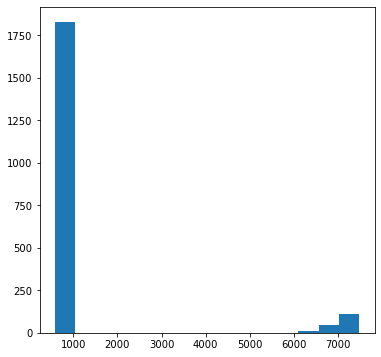

In [32]:
df_test_base['Credit Score'].hist(figsize=(6, 6), bins=15, grid=False)

Значения `Credit Score` более 6000 являются выбросами

<AxesSubplot:>

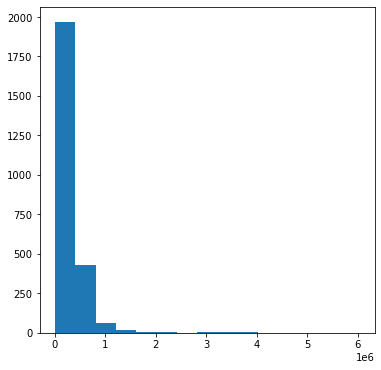

In [33]:
df_test_base['Current Credit Balance'].hist(
    figsize=(6, 6), bins=15, grid=False)

Значения `Current Credit Balance` более 200 000 также можно откорректировать

#### Анализ категориальных признаков

In [34]:
for cat_colname in df_train_base.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' +
          str(df_train_base[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

В целом тестовая и обучающая выборки сопоставимы по признакам. Имеют одинаковые проблемы с выбросами и пропусками. Следовательно могут обрабатываться одинаково.

### Анализ признакового пространства
#### Матрица корреляции признаков для обучающей выборки

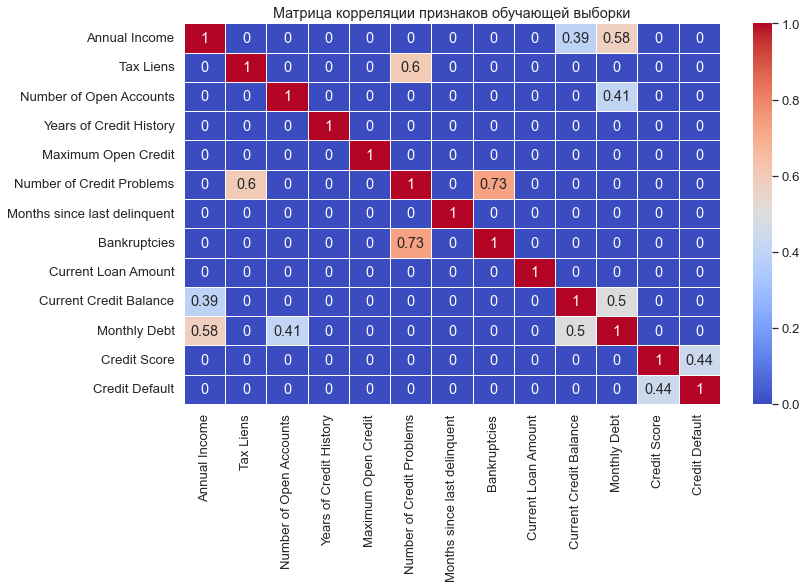

In [35]:
plt.figure(figsize=(12, 7))

sns.set(font_scale=1.2)

corr_matrix = df_train_base.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корреляции признаков обучающей выборки')
plt.show()

Видим сильную корреляцию ($\geq 0,5$) следующих признаков:
 - `'Number of Credit Problems'` $\iff$ `'Bankruptcies'` $=0,73$
 - `'Annual Income'` $\iff$ `'Monthly Debt'` $=0,58$
 - `'Tax Liens'` $\iff$ `'Number of Credit Problems'` $=0,6$
 - `'Monthly Debt'` $\iff$ `'Current Credit Balance'` $=0,5$

#### Матрица корреляции признаков для тестовой выборки

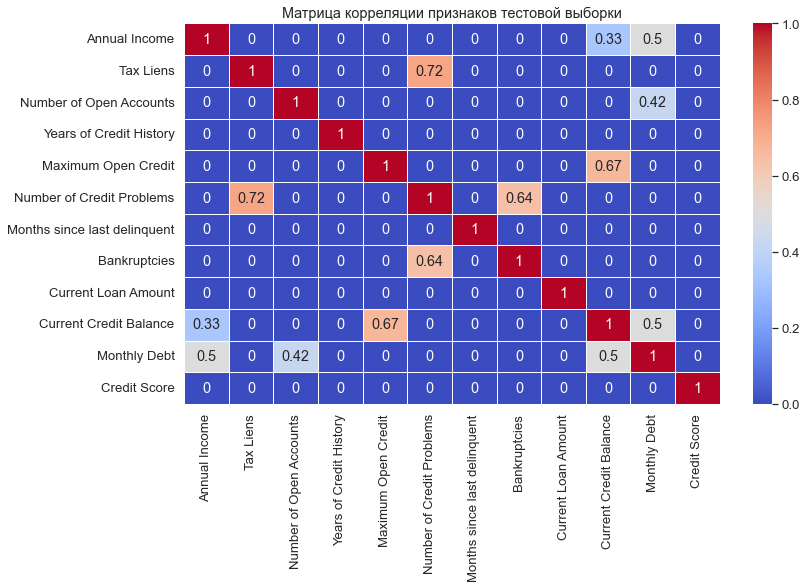

In [36]:
plt.figure(figsize=(12, 7))

sns.set(font_scale=1.2)

corr_matrix = df_test_base.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корреляции признаков тестовой выборки')
plt.show()

Сильная ($\geq 0,5$) корреляция сохраняется на том же уровне на тех же признаках, что и в обучающем сете:
 - `'Number of Credit Problems'` $\iff$ `'Bankruptcies'` $=0,64$
 - `'Annual Income'` $\iff$ `'Monthly Debt'` $=0,5$
 - `'Tax Liens'` $\iff$ `'Number of Credit Problems'` $=0,72$
 - `'Monthly Debt'` $\iff$ `'Current Credit Balance'` $=0,5$

Кроме того добавилась корреляция на признаках `'Current Credit Balance'` $\iff$ `'Maximum Open Credit'` $=0,67$

## Обработка признаков и подготовка датасета

Перед обработкой данных скопируем сеты в новые переменные и дальнейшие манипуляции будем проводить с ними.

In [37]:
df_train = df_train_base.copy()
df_test = df_test_base.copy()

#### Обработка категориальных признаков

`Home Ownership` и `Purpose` преведем в цифру вероятности возврата кредита, `Years in current job` переведем в численные значения, `Term` сделаем бинарным.

In [38]:
df_cat = df_train.groupby('Home Ownership', as_index=False).mean()[['Home Ownership', 'Credit Default']].rename(columns={
    'Credit Default': 'target_Home_Ownership'
})
df_cat = pd.DataFrame(df_cat)

df_train = df_train.merge(df_cat, on='Home Ownership', how='left')
df_test = df_test_base.merge(df_cat, on='Home Ownership', how='left')
df_train['Years in current job'] = df_train['Years in current job'].replace({'< 1 year': 0, '1 year': 1, '2 years': 2,
                                                                             '3 years': 3, '4 years': 4, '5 years': 5,
                                                                             '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10})

df_test['Years in current job'] = df_test['Years in current job'].replace({'< 1 year': 0, '1 year': 1, '2 years': 2,
                                                                           '3 years': 3, '4 years': 4, '5 years': 5,
                                                                           '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10})
df_cat = df_train.groupby('Purpose', as_index=False).mean()[['Purpose', 'Credit Default']].rename(columns={
    'Credit Default': 'target_Purpose'})
df_cat = pd.DataFrame(df_cat)
df_train = df_train.merge(df_cat, on='Purpose', how='left')
df_test = df_test.merge(df_cat, on='Purpose', how='left')

df_train['Term'] = df_train['Term'].map(
    {'Long Term': '1', 'Short Term': '2'}).astype(int)
df_test['Term'] = df_test['Term'].map(
    {'Long Term': '1', 'Short Term': '2'}).astype(int)

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   int32  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [40]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   float64
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   int32  
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

#### Генерация признаков

#### Сохранение подготовленных датасетов в файлы.

In [ ]:
df_train.to_csv('train_prep.csv', index=False)
df_test.to_csv('test_prep.csv', index=False)